### 🤖 What are Multi-Agent RAG Systems?
A Multi-Agent RAG System splits the RAG pipeline into multiple specialized agents — each responsible for a specific role — and enables them to collaborate on a single query or task.

#### 1. 📋 Multi-Agent Network RAG System with LangGraph
Project Overview

A Retrieval-Augmented Generation (RAG) system that uses a multi-agent architecture to intelligently answer questions from documents. Built with LangGraph v0.3 for workflow orchestration and OpenAI for language understanding.

What It Does

Transforms your documents (PDFs, text files) into a searchable knowledge base that can answer questions intelligently using AI. Simply upload documents and ask questions in natural language - the system finds relevant information and generates comprehensive answers.
Key Features

- 📚 Multi-Format Support: Handles PDF and text documents
- 🤖 3-Agent Architecture: Specialized agents for document processing, retrieval, and answer generation
- 🔍 Smart Search: Vector-based semantic search finds relevant information
- 💬 Natural Language Q&A: Ask questions in plain English


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
llm=init_chat_model("openai:gpt-4o-mini")
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x10bf76900>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x10bf77380>, root_client=<openai.OpenAI object at 0x10bf741a0>, root_async_client=<openai.AsyncOpenAI object at 0x10bf770e0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [3]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

/Users/aakritinag/Documents/GitHub/Agentic-RAG/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/Users/aakritinag/Documents/GitHub/Agentic-RAG/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [4]:
tavily_tool = TavilySearch(max_results = 5)

In [5]:
# generic function to create a retrieval tool
from langchain_core.tools import Tool

def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


internal_tool_1 = make_retriever_tool_from_text("internal_docs.txt",
                                              "InternalResearchNotes",
                                              "Search internal research notes for experimental results")

internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x10cef7ba0>)

In [6]:
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.agents import create_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [7]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [8]:
# Reaearch agent and node
from langchain_core.messages import SystemMessage

system_msg = SystemMessage(
    content="You can only do research. Use only bound tools. "
            "You are collaborating with a content writer."
)

llm_with_prompt = llm.bind(messages=[system_msg])

research_agent = create_agent(
    llm_with_prompt,
    tools=[internal_tool_1, tavily_tool]
)


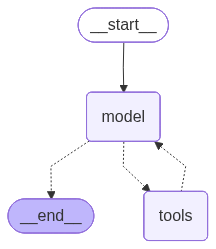

In [9]:
research_agent

In [10]:
# ## Reaearch node
# from typing import Literal

# def research_node(state:MessagesState)-> Command[Literal["blog_generator",END]]:
#     result = research_agent.invoke(state)
#     goto = get_next_node(result["messages"][-1], "blog_generator")

#     # wrap in a human message, as not all providers allow
#     # AI message at the last position of the input messages list
#     result["messages"][-1] = HumanMessage(
#         content=result["messages"][-1].content, name="researcher"
#     )
#     return Command(
#         update={
#             # share internal message history of research agent with other agents
#             "messages": result["messages"],
#         },
#         goto=goto,
#     )


In [11]:
from typing import Literal
def research_node(state: MessagesState) -> Command[Literal["blog_generator", END]]:
    result = research_agent.invoke(state)

    # always hand off once to blog
    goto = "blog_generator"
    

    # If researcher already produced final, end
    if "final answer" in (result["messages"][-1].content or "").lower():
        goto = END

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


In [12]:
# # Create blog agent 
# blog_agent = create_agent(
#     llm,
#     tools=[]
# )

# BLOG_SYSTEM = "You can only write a detailed blog. You are working with a researcher colleague."

# def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
#     # Inject system message at runtime
#     state_with_system = {
#         **state,
#         "messages": [SystemMessage(content=BLOG_SYSTEM)] + state["messages"]
#     }

#     result = blog_agent.invoke(state_with_system)

#     goto = get_next_node(result["messages"][-1], "researcher")

#     # Wrap final assistant output as HumanMessage for provider compatibility
#     result["messages"][-1] = HumanMessage(
#         content=result["messages"][-1].content,
#         name="blog_generator"
#     )

#     return Command(
#         update={"messages": result["messages"]},
#         goto=goto,
#     )


In [13]:
from langgraph.graph import END

blog_agent = create_agent(
    llm,
    tools=[]
)

BLOG_SYSTEM = "You can only write a detailed blog. You are working with a researcher colleague."

def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    # add system only once
    messages = state["messages"]
    if not (messages and isinstance(messages[0], SystemMessage) and messages[0].content == BLOG_SYSTEM):
        messages = [SystemMessage(content=BLOG_SYSTEM)] + messages

    result = blog_agent.invoke({**state, "messages": messages})

    # default: stop
    goto = END
    text = (result["messages"][-1].content or "").lower()
    if "need more research" in text or "need sources" in text or "researcher" in text:
        goto = "researcher"

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content,
        name="blog_generator"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


In [14]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

workflow = StateGraph(MessagesState)

workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)

# one pass flow
workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "blog_generator")
workflow.add_edge("blog_generator", END)

graph = workflow.compile()


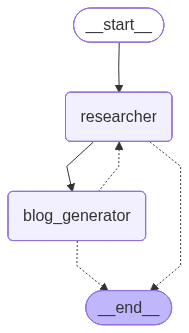

In [15]:
graph

In [16]:
from langchain_core.messages import HumanMessage

response = graph.invoke({
    "messages": [HumanMessage(content="Write a detailed blog on transformer variants for production")]
})


In [17]:
response["messages"][-1].content

'## Exploring Transformer Variants for Production: A Comprehensive Guide\n\n### Introduction\n\nIn the past few years, transformers have fundamentally reshaped the landscape of machine learning, particularly in the realm of natural language processing (NLP). Since the breakthrough introduction of the transformer model in the 2017 paper "Attention is All You Need," we have witnessed a proliferation of transformer variants. Each variant addresses specific challenges, aiming for improved performance, reduced computational costs, and expanded applicability across various domains such as image processing, speech recognition, and beyond. In this blog, we delve into the most prominent transformer variants, discuss their architectural innovations, efficiency enhancements, and practical applications in production environments.\n\n### Understanding the Transformer Architecture\n\nBefore examining these variants, it\'s crucial to establish a foundation by understanding the original transformer ar

### Multi Agent Suprvisor With RAG
Supervisor is a multi-agent architecture where specialized agents are coordinated by a central supervisor agent. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

In this tutorial, you will build a supervisor system with two agents — a research and a math expert. By the end of the tutorial you will:

1. Build specialized research and math agents
2. Build a supervisor for orchestrating them with the prebuilt langgraph-supervisor
3. Build a supervisor 
4. Implement advanced task delegation


In [18]:
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x10cef7ba0>)

In [19]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search

TavilySearch(max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

In [20]:
from langchain_core.messages import SystemMessage
from langchain_core.tools import tool

# ---- Tools ----
@tool
def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

@tool
def divide(a: float, b: float) -> float:
    """Divide two numbers."""
    return a / b


# ---- Research agent ----
research_system = SystemMessage(content=
    "You are a research agent.\n"
    "INSTRUCTIONS:\n"
    "- Assist ONLY with research-related tasks, DO NOT do any math\n"
    "- Use tools when needed\n"
    "- When done, respond with FINAL ANSWER followed by your research notes."
)

research_llm = llm.bind(messages=[research_system])

research_agent = create_agent(
    model=research_llm,
    tools=[internal_tool_1, tavily_tool],
    name="research_agent",
)

# ---- Math agent ----
math_system = SystemMessage(content=
    "You are a math agent.\n"
    "INSTRUCTIONS:\n"
    "- Assist ONLY with math-related tasks\n"
    "- Use tools for calculations\n"
    "- When done, respond with FINAL ANSWER followed by the result."
)

math_llm = llm.bind(messages=[math_system])

math_agent = create_agent(
    model=math_llm,
    tools=[add, multiply, divide],
    name="math_agent",
)


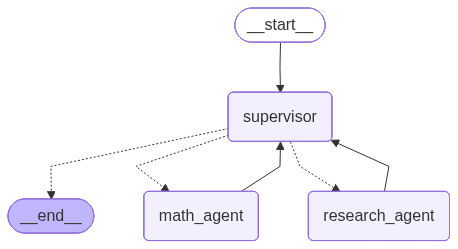

In [21]:
# create supervisor agent

from langgraph_supervisor import create_supervisor
supervisor=create_supervisor(
    model=llm,
    agents=[research_agent,math_agent],
    prompt=(
         "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."

    ),
    add_handoff_back_messages=True,
    output_mode="full_history"
).compile()

supervisor

In [22]:
response=supervisor.invoke({"messages":" list all the transformer variants in production deployments from the retriever and then tell me what is 5 plus 10"})

📚 Using tool: InternalResearchNotes


In [23]:
response

{'messages': [HumanMessage(content=' list all the transformer variants in production deployments from the retriever and then tell me what is 5 plus 10', additional_kwargs={}, response_metadata={}, id='1b1106f4-45c5-4854-aaf4-890b351c5930'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 142, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bbc38b4db', 'id': 'chatcmpl-CzMHlEn0TjzxhoAhOpSFXiivrWECJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='lc_run--019bd11a-20b2-7bd3-a42f-9520cf48f900-0', tool_calls=[{'name': 'transfer_to_research_agent', 'args': {}, 'id': 'call_lUwSftaZ0H

In [24]:
response["messages"][-1].content

'I have successfully gathered the information on transformer variants in production deployments. Additionally, I confirmed that 5 plus 10 equals 15. \n\nIf you need further assistance, please let me know!'

### Hierarchical Agent Teams With RAG
In the Agent Supervisor, the concept of a single supervisor node to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed hierarchically.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

In [136]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)

In [137]:
from typing import List
from langchain_core.tools import tool
import requests
from bs4 import BeautifulSoup

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Scrape provided web pages for detailed information (with timeouts)."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/120.0.0.0 Safari/537.36"
    }

    out = []
    for url in urls:
        try:
            r = requests.get(url, headers=headers, timeout=(5, 15))  # connect, read timeout
            r.raise_for_status()

            soup = BeautifulSoup(r.text, "html.parser")

            title = soup.title.get_text(strip=True) if soup.title else ""
            text = soup.get_text("\n", strip=True)

            out.append(f'<Document name="{title}">\n{text[:12000]}\n</Document>')  # cap size

        except Exception as e:
            out.append(f'<Document name="">\nERROR scraping {url}: {repr(e)}\n</Document>')

    return "\n\n".join(out)


In [139]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [140]:
WORKING_DIRECTORY

PosixPath('/var/folders/m4/yx3n91cs37nf91mrrvjx9s2r0000gn/T/tmp978pjvvy')

In [141]:
# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [142]:
def add_called(existing: list[str] | None, new: list[str] | None) -> list[str]:
    existing = existing or []
    new = new or []
    out = []
    for x in existing + new:
        if x not in out:
            out.append(x)
    return out

In [143]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages
from langchain_core.messages import AIMessage

    
class State(MessagesState, TypedDict):
    next: str
    called: Annotated[list[str], add_called]


In [154]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import END
from langgraph.types import Command

def make_supervisor_node(llm: BaseChatModel, members: list[str]):

    options = ["FINISH"] + members

    #  f-string so members is real text, not "{members}"
    system_prompt = (
        f"You are a supervisor managing workers: {members}.\n"
        "Pick ONE worker to act next.\n"
        "Rules:\n"
        "- Prefer calling each worker at most once.\n"
        "- If a worker already replied, do NOT call them again unless absolutely necessary.\n"
        "- If you have enough information to satisfy the user, respond with FINISH.\n"
        "Return ONLY one of: " + " | ".join(options)
    )

    class Router(TypedDict):
        next: Literal[*options]

    # def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    #     # --- Deterministic stop: if all members have replied once -> FINISH
    #     called = set(state.get("called", []))
    #     # if set(members).issubset(called):
    #     #     return Command(goto=END, update={"next": END})
        
    #     if set(members).issubset(called):
    #         return Command(goto=END, update={"next": END, "called": list(called)})


    #     # --- Only allow remaining workers (optional but helps)
    #     remaining = [m for m in members if m not in called]
    #     allowed = ["FINISH"] + remaining

    #     class RouterRemaining(TypedDict):
    #         next: Literal[*allowed]

    #     messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    #     response = llm.with_structured_output(RouterRemaining).invoke(messages)

    #     goto = response["next"]
    #     if goto == "FINISH":
    #         goto = END

    #     #return Command(goto=goto, update={"next": goto})
    #     return Command(goto=goto, update={"next": goto, "called": list(state.get("called", []))})
    
    
    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        called = set(state.get("called", []))

        # finish if all members called
        if set(members).issubset(called) and members:
            return Command(goto="__end__", update={"next": "__end__", "called": list(called)})

        remaining = [m for m in members if m not in called]

        # ✅ Only allow FINISH after at least one worker has been called
        allow_finish = len(called) > 0
        allowed = (["FINISH"] if allow_finish else []) + remaining

        class RouterRemaining(TypedDict):
            next: Literal[*allowed]

        messages = [{"role": "system", "content": system_prompt}] + state["messages"]
        response = llm.with_structured_output(RouterRemaining).invoke(messages)

        goto = response["next"]
        if goto == "FINISH":
            goto = "__end__"

        return Command(goto=goto, update={"next": goto, "called": list(state.get("called", []))})




    return supervisor_node


In [155]:
# generic function to create a retrieval tool
from langchain_core.tools import Tool

def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


internal_tool_1 = make_retriever_tool_from_text("research_notes.txt",
                                              "InternalResearchNotes",
                                              "Search internal research notes for experimental results")

internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x119a3ee80>)

In [156]:
internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x119a3ee80>)

In [157]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent


search_agent = create_agent(llm, tools=[tavily_tool,internal_tool_1])
search_agent

    
# def search_node(state: State) -> Command[Literal["supervisor"]]:
#     result = search_agent.invoke(state)
#     return Command(
#         update={
#             "messages": state["messages"] + [
#                 HumanMessage(content=result["messages"][-1].content, name="search")
#             ],
#             "called": ["search"],
#         },
#         goto="supervisor",
#     )
    
def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="search")
            ],
            "called": ["search"],
        },
        goto="supervisor",
    )



### sub agent
web_scraper_agent = create_agent(llm, tools=[scrape_webpages])

    
# def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
#     result = web_scraper_agent.invoke(state)
#     return Command(
#         update={
#             "messages": state["messages"] + [
#                 HumanMessage(content=result["messages"][-1].content, name="web_scraper")
#             ],
#             "called": ["web_scraper"],
#         },
#         goto="supervisor",
#     )
    
def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="web_scraper")
            ],
            "called": ["web_scraper"],
        },
        goto="supervisor",
    )




In [158]:
research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])
research_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['search', 'web_scraper', '__end__']]>

In [159]:
# research_builder = StateGraph(State)
# research_builder.add_node("supervisor", research_supervisor_node)
# research_builder.add_node("search", search_node)
# research_builder.add_node("web_scraper", web_scraper_node)

# research_builder.add_edge(START, "supervisor")

# # supervisor -> workers
# research_builder.add_edge("supervisor", "search")
# research_builder.add_edge("supervisor", "web_scraper")

# # workers -> supervisor (handoff back)
# research_builder.add_edge("search", "supervisor")
# research_builder.add_edge("web_scraper", "supervisor")

# # allow finish
# research_builder.add_edge("supervisor", END)

# research_graph = research_builder.compile()


research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")

# ✅ Conditional routing based on state["next"]
research_builder.add_conditional_edges(
    "supervisor",
    lambda s: s["next"],
    {
        "search": "search",
        "web_scraper": "web_scraper",
        "__end__": END,
    },
)

# workers always report back
research_builder.add_edge("search", "supervisor")
research_builder.add_edge("web_scraper", "supervisor")

research_graph = research_builder.compile()



In [160]:
for i, m in enumerate(out["messages"][-10:], start=max(0, len(out["messages"])-10)):
    print(i, type(m), getattr(m, "type", None), getattr(m, "name", None), str(getattr(m, "content", m))[:80])
print("called:", out.get("called"))
print("next:", out.get("next"))


0 <class 'langchain_core.messages.human.HumanMessage'> human None Give me 3 key points on Longformer vs Reformer
called: []
next: __end__


In [161]:
print(research_graph)

In [162]:
# out = research_graph.invoke(
#     {"messages": [("user", "Give me 3 key points on Longformer vs Reformer")], "called": []},
#     config={"recursion_limit": 10}
# )
# print(out.get("called"))
# print(out["messages"][-1].content[:300])

out = research_graph.invoke(
    {"messages": [("user", "Give me 3 key points on Longformer vs Reformer")],
     "called": [],
     "next": "search"},
    config={"recursion_limit": 10}
)



📚 Using tool: InternalResearchNotes
📚 Using tool: InternalResearchNotes


In [163]:
from langchain_core.messages import AIMessage

last_ai = next(m for m in reversed(out["messages"]) if isinstance(m, AIMessage))
print("called:", out.get("called"))
print(last_ai.content[:300])


called: ['search']
Here are three key points comparing Longformer and Reformer:

### Longformer
1. **Chunk-Based Hybrid Attention:** Longformer utilizes chunk-based hybrid attention, which allows it to process longer sequences (up to 8192 tokens) efficiently. This helps in reducing latency per query, although in a str


In [164]:
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

In [165]:
from langchain_core.messages import SystemMessage

doc_writer_agent = create_agent(
    llm.bind(messages=[SystemMessage(content=
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    )]),
    tools=[write_document, edit_document, read_document],
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ],
            "called": ["doc_writer"],
        },
        goto="supervisor",
    )



note_taking_agent = create_agent(
    llm.bind(messages=[SystemMessage(content=
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    )]),
    tools=[create_outline, read_document],
)



def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ],
            "called": ["note_taker"],
        },
        goto="supervisor",
    )



doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker"])

In [166]:
# doc_builder = StateGraph(State)
# doc_builder.add_node("supervisor", doc_writing_supervisor_node)
# doc_builder.add_node("doc_writer", doc_writing_node)
# doc_builder.add_node("note_taker", note_taking_node)
# #doc_builder.add_node("chart_generator", chart_generating_node)

# doc_builder.add_edge(START, "supervisor")

# doc_builder.add_edge("supervisor", "doc_writer")
# doc_builder.add_edge("supervisor", "note_taker")
# #doc_builder.add_edge("supervisor", "chart_generator")

# doc_builder.add_edge("doc_writer", "supervisor")
# doc_builder.add_edge("note_taker", "supervisor")
# #doc_builder.add_edge("chart_generator", "supervisor")

# doc_builder.add_edge("supervisor", END)

# doc_graph = doc_builder.compile()



doc_builder = StateGraph(State)
doc_builder.add_node("supervisor", doc_writing_supervisor_node)
doc_builder.add_node("doc_writer", doc_writing_node)
doc_builder.add_node("note_taker", note_taking_node)


doc_builder.add_edge(START, "supervisor")

doc_builder.add_conditional_edges(
    "supervisor",
    lambda s: s["next"],
    {
        "doc_writer": "doc_writer",
        "note_taker": "note_taker",
        "__end__": END,
    },
)

doc_builder.add_edge("doc_writer", "supervisor")
doc_builder.add_edge("note_taker", "supervisor")

doc_graph = doc_builder.compile()



In [167]:
print(doc_graph)

In [168]:
from langchain_core.messages import BaseMessage
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])
teams_supervisor_node

<function __main__.make_supervisor_node.<locals>.supervisor_node(state: __main__.State) -> langgraph.types.Command[typing.Literal['research_team', 'writing_team', '__end__']]>

In [169]:

    
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke(
        {"messages": state["messages"], "called": []},   
        config={"recursion_limit": 6}                   
    )
    return Command(
        update={
            "messages": state["messages"] + [
                HumanMessage(content=response["messages"][-1].content, name="research_team")
            ]
        },
        goto="supervisor",
    )


    
def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = doc_graph.invoke(
        {"messages": state["messages"], "called": []},   # keep called local to subgraph
        config={"recursion_limit": 10}
    )
    return Command(
        update={
            "messages": state["messages"] + [
                HumanMessage(content=response["messages"][-1].content, name="writing_team")
            ]
        },
        goto="supervisor",
    )


# super_builder = StateGraph(State)
# super_builder.add_node("supervisor", teams_supervisor_node)
# super_builder.add_node("research_team", call_research_team)
# super_builder.add_node("writing_team", call_paper_writing_team)

# super_builder.add_edge(START, "supervisor")

# # supervisor can route to both teams + END
# super_builder.add_edge("supervisor", "research_team")
# super_builder.add_edge("supervisor", "writing_team")
# super_builder.add_edge("supervisor", END)

# # teams always report back
# super_builder.add_edge("research_team", "supervisor")
# super_builder.add_edge("writing_team", "supervisor")

# super_graph = super_builder.compile()
# super_graph

super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")

super_builder.add_conditional_edges(
    "supervisor",
    lambda s: s["next"],
    {
        "research_team": "research_team",
        "writing_team": "writing_team",
        "__end__": END,
    },
)

super_builder.add_edge("research_team", "supervisor")
super_builder.add_edge("writing_team", "supervisor")

super_graph = super_builder.compile()


In [170]:
response = super_graph.invoke(
    {"messages": [("user", "Write about transformer variants in production deployments.")], "called": []},
    config={"recursion_limit": 15}
)


In [171]:
response

{'messages': [HumanMessage(content='Write about transformer variants in production deployments.', additional_kwargs={}, response_metadata={}, id='c7ac6d55-6bc5-45d0-ba60-334ef4787f3f'),
  HumanMessage(content="### Transformer Variants in Production Deployments\n\nTransformers have substantially transformed the landscape of natural language processing (NLP) and other AI applications. Below, we explore a few key transformer variants and considerations for their deployment in production environments.\n\n#### Major Transformer Variants\n1. **BERT (Bidirectional Encoder Representations from Transformers)**: Developed by Google and integrated into its search engine, BERT improves the understanding of words in context, enhancing the relevancy of search results for ambiguous queries.\n\n2. **GPT (Generative Pre-trained Transformer)**: Known for its capability to generate coherent text, GPT has found applications in chatbots and content creation.\n\n3. **LLaMA (Large Language Model Meta AI)**: 

In [172]:
response["messages"][-1].content

"### Transformer Variants in Production Deployments\n\nTransformers have substantially transformed the landscape of natural language processing (NLP) and other AI applications. Below, we explore a few key transformer variants and considerations for their deployment in production environments.\n\n#### Major Transformer Variants\n1. **BERT (Bidirectional Encoder Representations from Transformers)**: Developed by Google and integrated into its search engine, BERT improves the understanding of words in context, enhancing the relevancy of search results for ambiguous queries.\n\n2. **GPT (Generative Pre-trained Transformer)**: Known for its capability to generate coherent text, GPT has found applications in chatbots and content creation.\n\n3. **LLaMA (Large Language Model Meta AI)**: This model focuses on providing efficient performance metrics while reducing resource demand, important for handling large inputs effectively.\n\nThese models vary based on their architecture and training meth